## Application of CNN Object Detection Algorithm to Street View Imagery

In this practical, we will run an object detection algorithm on street view images in two London boroughs. We then examine correlates of the extracted image features with census variables.

### Learning Objectives
* Be able to load image data and learm about sources of imagery
* Load model for object detection and run inference on the image dataset
* Examine the counts, correlations and spatial distribution of image features
* Analyse the trends in object counts for different areas and the corresponding census statistics

### Content
1. Dataset
2. Tensorflow API
3. Object Detection
4. Analysis of Results
5. Census  Statistics

### 1. Dataset 
In this tutorial we will be using Street View Imagery. The imagery has been obtained from OpenStreetCams (https://openstreetcam.org/). OpenStreetCams (which has now become known as KartaView) is a platform for collecting and providing free and open street level imagery. All the images are photographed and submitted by users and tagged with metadata for their location and time. As a result, the images are not as consistent in the height and field of view as they are for Google Street View imagery, nor is the coverage as extensive. However, they have enough data available for London under a less restrictive license for purposes of this tutorial.

Here, we have obtained approximately 20k images within a 1km radius from Central London (Trafalgar Square) using their API (http://api.openstreetcam.org/api/doc.html). Each image has been obtained with a corresponding latitude and longitude, making it possible to use the images for a spatial analysis. In this tutorial, you will apply a pre-trained object detection algorithm over this imagery to extract the features and obtain spatial patterns based on the location metadata provided by each image. 

In the folder "/sample", you can see a selection of 25 of these images.

With reference to the lecture, consider before you move on:

* What are the strengths and weaknesses of using this kind of imagery?
    * What can and can't we see from these sorts of images?
    * What issues might there be from taking images too far apart or close together? 
    * Do the images reflect what you normally see while you walk through London? If not, how do they differ?
    * If you had to design a data collection campaign to obtain Street View Images, how might you do so?

### 2. Tensorflow API
The TensorFlow Object Detection API is an open-source framework built on top of TensorFlow that makes it easy to construct, train and deploy object detection models. There are already pre-trained models in their framework which are referred to as Model Zoo. More info about the Tensorflow API (https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html).


#### 2.1 Installing the TensorFlow API

This can be a bit tricky. We will begin by installing packages. Those which are not already present in the Jupyter environment using the !pip command. If you get an error for pip installation. Try adding *--user* to the end of each line.

In [2]:
# !pip install -U --pre tensorflow=="2.*"
# !pip install tf_slim
# !pip install pycocotools
#!pip install seaborn 
#!pip install geopandas 

Get tensorflow/models by cloning the tensorflow/models github repository:

In [1]:
## clone the tensorflow models github repository
import pathlib
import os
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In order to successfully install the object detection API, you will need to open a bash terminal. Make sure to run the ```%bash``` parts of the code in the terminal. Installation will take a few minutes:

In [5]:
%%bash
# cd models/research/
# protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
# cp object_detection/packages/tf2/setup.py .
# python -m pip install .

To load the object detection utils, change into the models/research directory which we cloned from github above (your path might be different to adjust as necessary):

In [2]:
print (os.getcwd())
os.chdir('models/research')
print (os.getcwd())

/rds/general/user/abm1818/home/GTA
/rds/general/user/abm1818/home/GTA/models/research


In [ ]:
# change back to the root directory afterwards
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
os.chdir('../..')
print (os.getcwd())

Great we now have access to TensorFlow Object Detection API where we will load the Object Detection model from.


### 3. Object detection

In this section, we will introduce the object detection architecture, install the Tensorflow Object Detection API, load the model and run inference on the dataset.

#### 3.1 Choosing a model architecture: MobileNet-SSD
Recall from Wenjai's lectures, the two stage Object Detection algorithm named Faster R-CNN. This algorithm is made up of the region proposal network (RPN) and the detection network. This architecture continues to feature in some of the top performing networks (see https://paperswithcode.com/sota/object-detection-on-coco). 

However, in the interest of processing time and memory, we chose the <b>MobileNet-SSD for the tutorial</b>. 

Depending on your time/accuracy trade-off, you can choose the appropriate model from the TensorFlow API. If we want a high-speed model the single-shot detection (SSD) network works best. As its name suggests, the SSD network determines all bounding box probabilities in one go; hence, it is much faster than the two stage R-CNN.
The SSD architecture is a single convolution network that learns to predict bounding box locations and classify these locations in one pass. Hence, SSD can be trained end-to-end. The SSD network consists of a base architecture (MobileNet in this case) followed by several convolution layers:

![Drag Racing](images/mobileNet-SSD-network-architecture.png)

The SSD's operates on feature maps to detect the location of bounding boxes. Recall – a feature map is of the size Df * Df * M. For each feature map location, k bounding boxes are predicted. Each bounding box carries with it the following information:
 - 4 corner bounding box offset locations (cx, cy, w, h)
 - C class probabilities (c1, c2, …cp)
 
SSD does not predict the shape of the box, rather just where the box is. The k bounding boxes each have a predetermined shape. The shapes are set prior to actual training. For example, in the figure above, there are 5 boxes, meaning k=5.

In [10]:
import numpy as np
import pandas as pd
import glob
import sys
import ast
import tarfile
import tensorflow as tf
import zipfile
import time
import geopandas

import six.moves.urllib as urllib
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
%matplotlib inline

import warnings
#warnings.filterwarnings('ignore')   # Suppress Matplotlib warning

#### 3.2 Load Model

Since we have successfully downloaded the Object Detection API, we will load the SSD MobileNet model.

The code snippet shown below is used to download the pre-trained object detection model we shall use to perform inference. The particular detection algorithm we will use is the SSD mobilenet 640x640. More models can be found in the TensorFlow Object Detection Model Zoo (https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md):

In [13]:
# Download and extract model
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

MODEL_DATE = '20200711'
MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

Next, we download the labels file (.pbtxt). This contains a list of strings used to add the correct label to each detection (e.g. person). Since the pre-trained model we will use has been trained on the COCO dataset, we will need to download the labels file corresponding to this dataset, named mscoco_label_map.pbtxt:

In [14]:
# Download labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)

Next we load the model:

In [15]:
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 23.238362312316895 seconds


#### 3.3 Load label map data (for plotting)
Label maps join numerical indices to category names, so that when the CNN predicts 5, we know that this corresponds to the object: airplane. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [16]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

#### 3.4 Running Inference on the Image Dataset
The code shown below loads an image, runs it through the detection model and visualizes the detection results, including the keypoints.

Note that this will take a long time (several minutes) the first time you run this code due to tf.function’s trace-compilation — on subsequent runs (e.g. on new images), things will be faster.

Print out detections[‘detection_boxes’] and try to match the box locations to the boxes in the image. Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).

Set min_score_thresh to other values (between 0 and 1) to allow more detections in or to filter out more detections.

In [1]:
#os.getcwd()

In [29]:
img_folder = 'OpenStreetCams_London/images/*'

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

def run_inference_for_single_image(model, image):
    
    image = load_image_into_numpy_array(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    #model_fn = model.signatures['serving_default']
    output_dict = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                   image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return image, output_dict

Let's visualise inference on just 5 of the images:

Running inference for OpenStreetCams_London/images/989624406.jpg... Done
Running inference for OpenStreetCams_London/images/1199720425.jpg... Done
Running inference for OpenStreetCams_London/images/988762138.jpg... Done
Running inference for OpenStreetCams_London/images/988244918.jpg... Done


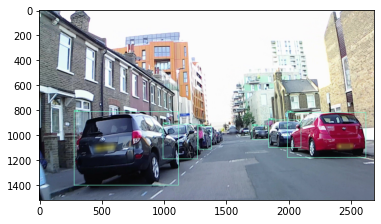

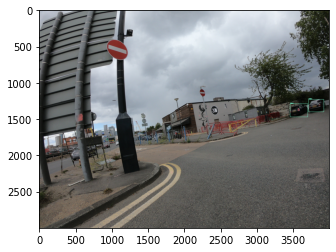

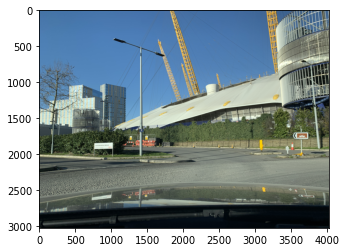

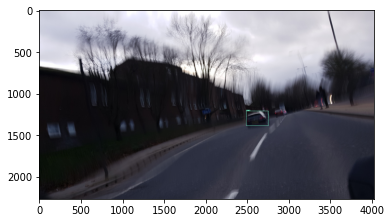

In [30]:
for image_path in glob.glob(img_folder)[1:5]:
    print('Running inference for {}... '.format(image_path), end='')
    
    # RUN INFERENCE
    image_np, detections = run_inference_for_single_image(detect_fn, image_path)
    
    # Visualise Detection
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.50,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()

#sphinx_gallery_thumbnail_number = 2

The Tensorflow API saves the results the in the detection object that contains multiple dictionaries:

In [31]:
for i in detections:
    print (i)

detection_multiclass_scores
raw_detection_scores
raw_detection_boxes
detection_anchor_indices
detection_boxes
detection_classes
detection_scores
num_detections


Now we will run inference on the entire dataset, storing the detection results in a dictionary:

In [35]:
def run_on_all_images(imgs_folder='imgs/*.png'):
    output_dicts = []
    images = glob.glob(imgs_folder)[:50]
    corrupts = []
    for ix, image in enumerate(images):
        try:
            im, output_dict = run_inference_for_single_image(detect_fn, image)
        #print (images[ix])
            output_dicts.append(output_dict)
        except:
            corrupts.append(image)
        print ('Run inference on image %s' % ix)
    return output_dicts, corrupts

In [36]:
#%%capture
import time
start_time = time.time()
det, corrupts = run_on_all_images(img_folder)
end_time = time.time()
print ('Takes %s seconds to run' % str(end_time - start_time))

Run inference on image 0
Run inference on image 1
Run inference on image 2
Run inference on image 3
Run inference on image 4
Run inference on image 5
Run inference on image 6
Run inference on image 7
Run inference on image 8
Run inference on image 9
Run inference on image 10
Run inference on image 11
Run inference on image 12
Run inference on image 13
Run inference on image 14
Run inference on image 15
Run inference on image 16
Run inference on image 17
Run inference on image 18
Run inference on image 19
Run inference on image 20
Run inference on image 21
Run inference on image 22
Run inference on image 23
Run inference on image 24
Run inference on image 25
Run inference on image 26
Run inference on image 27
Run inference on image 28
Run inference on image 29
Run inference on image 30
Run inference on image 31
Run inference on image 32
Run inference on image 33
Run inference on image 34
Run inference on image 35
Run inference on image 36
Run inference on image 37
Run inference on image

Notice that inference was only done on 50 images. The entire image dataset has 18K images in, and it will take almost 3 hours to run on the current CPU specs.

Time is an important feature of any Machine Learning pipeline, and it can be made more efficient with the use of GPU's. As you may know, the university has GPU allocations as part of the HPC service. This means models can be trialed and optimised quickly and in parallel by requesting multiple GPU access.

Don't worry about this for now, you will see below we have run inference on the full image dataset ahead of time to save you the compute time.

#### 3.5 Converting detected objects into DataFrame
We will make the data more manageable for subsequent analysis

In [139]:
detect_scores = []
detect_classes = []
detect_ymin = []
detect_xmin = []
detect_ymax = []
detect_xmax = []
Id_list = []

images = glob.glob(img_folder)

for img, output_dict in zip(images, det):
    cut_off_scores = len(list(filter(lambda x: x >= 0.5, output_dict['detection_scores'])))
    detect_score = []
    detect_class = []
    for j in range(cut_off_scores):
        detect_score.append(output_dict['detection_scores'][j])
        detect_class.append(output_dict['detection_classes'][j])
    detect_scores.append(detect_score)
    detect_classes.append(detect_class)
    fname = os.path.basename(img)
    Id_list.append(fname)
    #Id_list.append()
Detected_objects = pd.DataFrame(
        {'Image': Id_list,
         'Score': detect_scores,
         'Class': detect_classes})

In [103]:
Detected_objects.head()

,Image,Score,Class
0,1199897341.jpg,"[0.7339361, 0.53107554, 0.5184331]","[3, 13, 8]"
1,989624406.jpg,"[0.7398396, 0.6525004, 0.6446687, 0.6435848, 0...","[3, 3, 3, 3, 3, 3]"
2,1199720425.jpg,"[0.67206126, 0.57164204]","[3, 3]"
3,988762138.jpg,[],[]
4,988244918.jpg,[0.6996728],[3]


We will now import the dataframe for inference on the entire dataset:

In [142]:
Detected_objects = pd.read_csv('one_we_made_earlier.csv', index_col=False)
Detected_objects = Detected_objects.drop('Unnamed: 0', axis=1)

In [160]:
Detected_objects['Class'] = Detected_objects['Class'].map(ast.literal_eval)
Detected_objects['Score'] = Detected_objects['Score'].map(ast.literal_eval)

In [161]:
Detected_objects.head()

,Image,Score,Class
0,1199895301.jpg,[],[]
1,1199862845.jpg,"[0.66176516, 0.6096716, 0.6091193, 0.50782275]","[3, 3, 3, 8]"
2,1199831213.jpg,"[0.66687167, 0.55976176]","[3, 3]"
3,1199785717.jpg,"[0.7605931, 0.6726467, 0.5430512]","[3, 3, 3]"
4,989952522.jpg,[0.7893248],[3]


In [162]:
## Create a dictionary with the labels from the COCO dataset
coco_dict = category_index.values()
coco = pd.DataFrame(coco_dict)
coco = pd.Series(coco.name.values,index=coco.id).to_dict()

### 4 Analysis of Results
Let's perform some analysis to find out more about the features extracted from the model.

We will first create a function to plot total object counts:

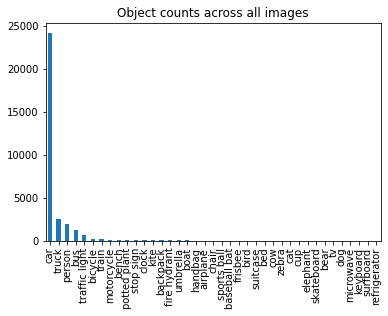

In [163]:
# Create a row for each Class element
lst_col = 'Class'
df = pd.DataFrame({
      col:np.repeat(Detected_objects[col].values, Detected_objects[lst_col].str.len())
      for col in Detected_objects.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(Detected_objects[lst_col].values)})[Detected_objects.columns]
df = df.drop('Score', axis = 1)

# Maps class integer to object name
df['Name'] = df['Class'].astype(int)
df['Name'] = df['Name'].map(coco)      

# plot total counts across all images
df['Name'].value_counts().plot.bar()
plt.title('Object counts across all images')
plt.show()

Let's take a look at the correlations between objects counts in a single image, across all images. What objects tend to appear together in the imagery?

In [164]:
# plot correlations between counts in a single image, across all images
### POINT BASED ANALYSIS
obj_df_img = pd.crosstab(df.Image, df.Name)
obj_df_img = obj_df_img.groupby(['Image']).sum()
obj_df_img.head()

Name,airplane,backpack,baseball bat,bear,bed,bench,bicycle,bird,boat,bus,...,sports ball,stop sign,suitcase,surfboard,traffic light,train,truck,tv,umbrella,zebra
Image,,,,,,,,,,,,,,,,,,,,,
1061395438.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1061396670.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1061396918.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1061397154.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1061397414.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
obj_df_img.columns

Index(['airplane', 'backpack', 'baseball bat', 'bear', 'bed', 'bench',
       'bicycle', 'bird', 'boat', 'bus', 'car', 'cat', 'chair', 'clock', 'cow',
       'cup', 'dog', 'elephant', 'fire hydrant', 'frisbee', 'handbag',
       'keyboard', 'kite', 'microwave', 'motorcycle', 'person', 'potted plant',
       'refrigerator', 'skateboard', 'sports ball', 'stop sign', 'suitcase',
       'surfboard', 'traffic light', 'train', 'truck', 'tv', 'umbrella',
       'zebra'],
      dtype='object', name='Name')

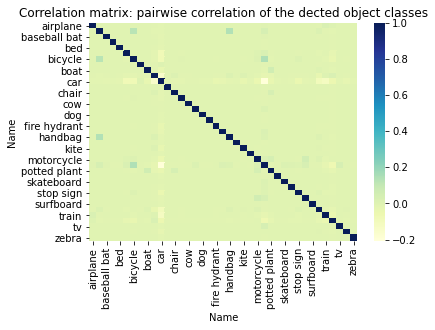

In [166]:
corr = obj_df_img.corr()
ax = sns.heatmap(corr, cmap="YlGnBu").set_title("Correlation matrix: pairwise correlation of the dected object classes")

#### 4.1 GIS

Let's visualise where the images are by importing the metadata. This metadata gives the image_ID, file_name, latitude, longitude, when the image was captured, income estimates and education estimates:

In [167]:
# geoplot images and colour by density of object count
meta = pd.read_csv('image_metadata_income_education.csv')
meta.head()

,image_ID,file_name,latitude,longitude,shot_date,LSOA11CD,LSOA11NM,inc_mean_1,inc_median,inc_mean_d,inc_medi_1,p_edu_a,p_edu_b,edu_score,edu_decile
0,1199865345,1199865345.jpg,51.476846,0.008262,2020/11/09 16:12:37,E01001580,Greenwich 021A,66990.0,51300.0,9.0,10.0,0.786385,0.708138,0.747261,10.0
1,1199865601,1199865601.jpg,51.476262,0.008858,2020/11/09 16:12:44,E01001580,Greenwich 021A,66990.0,51300.0,9.0,10.0,0.786385,0.708138,0.747261,10.0
2,1199865393,1199865393.jpg,51.476773,0.008332,2020/11/09 16:12:38,E01001580,Greenwich 021A,66990.0,51300.0,9.0,10.0,0.786385,0.708138,0.747261,10.0
3,1199865425,1199865425.jpg,51.476696,0.008410,2020/11/09 16:12:39,E01001580,Greenwich 021A,66990.0,51300.0,9.0,10.0,0.786385,0.708138,0.747261,10.0
4,1199865453,1199865453.jpg,51.476607,0.008498,2020/11/09 16:12:40,E01001580,Greenwich 021A,66990.0,51300.0,9.0,10.0,0.786385,0.708138,0.747261,10.0


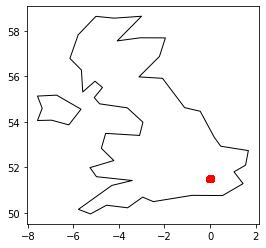

In [168]:
geo = geopandas.GeoDataFrame(
    meta, geometry=geopandas.points_from_xy(meta.longitude, meta.latitude))

# import world base layer
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to the UK.
ax = world[world.name == "United Kingdom"].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
geo.plot(ax=ax, color='red')
plt.show()

Let's load a London only shapefile:

In [169]:
ldn_shape = 'shape/greater_london_outcome_boundaries.shp'
ldn = geopandas.read_file(ldn_shape)

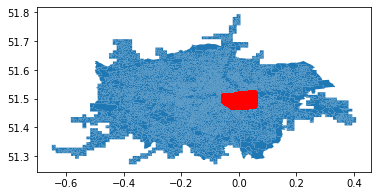

In [170]:
ax = ldn.plot()
geo.plot(ax=ax, color='red')
plt.show()

Let's crop to the area where our images are located

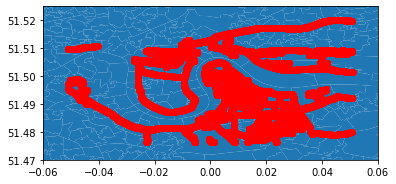

In [171]:
ax = ldn.plot()
ax.set_xlim([-0.06,0.06])
ax.set_ylim([51.47,51.525])
geo.plot(ax=ax, color='red')
plt.show()

We will now merge the metadata file to our object counts:

In [172]:
merged = meta.merge(obj_df_img, left_on='file_name', right_index=True)
LSOA_with_OBJECTCOUNTS = merged.groupby(['LSOA11CD']).sum()
ldn_counts = ldn.merge(LSOA_with_OBJECTCOUNTS, left_on='lsoa11cd', right_index=True, indicator=True)
ldn_counts.head()

,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,label,name,code,DN,...,stop sign,suitcase,surfboard,traffic light,train,truck,tv,umbrella,zebra,_merge
2562,2356,E01001580,Greenwich 021A,Greenwich 021A,297607.683797,3930.386884,E09000023,Lewisham,E09000023,1761.0,...,0,0,0,5,1,23,0,0,0,both
2563,2356,E01001580,Greenwich 021A,Greenwich 021A,297607.683797,3930.386884,E09000011,Greenwich,E09000011,1761.0,...,0,0,0,5,1,23,0,0,0,both
2564,2357,E01001581,Greenwich 016A,Greenwich 016A,208869.733947,3429.366217,E09000011,Greenwich,E09000011,1761.0,...,2,0,0,8,2,17,0,1,0,both
2570,2361,E01001585,Greenwich 016B,Greenwich 016B,179181.210293,3638.680367,E09000011,Greenwich,E09000011,1761.0,...,0,0,0,2,1,8,0,0,0,both
2571,2362,E01001586,Greenwich 016C,Greenwich 016C,214011.609638,3778.610778,E09000011,Greenwich,E09000011,1761.0,...,0,0,0,7,2,29,0,1,0,both


and we can colour LSOA's by object counts to examine the spatial distribution of objects detected in the images:

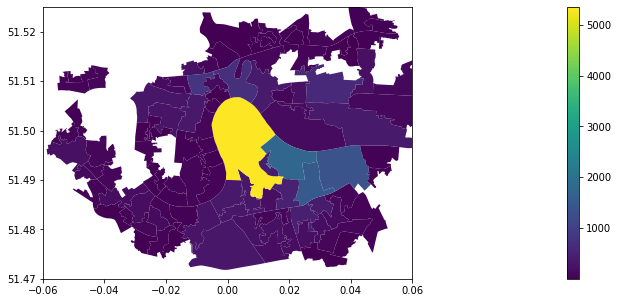

In [173]:
VARIABLE = 'car' # change the object type

fig, ax = plt.subplots(figsize=(15, 5))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.6)
ldn_counts.plot(column=VARIABLE, cmap='viridis',legend=True, ax=ax, cax=cax )
ax.set_xlim([-0.06,0.06])
ax.set_ylim([51.47,51.525])
plt.show()

### 5 Further Analysis

- Note here that each LSOA has a different number of images in it. Can you change the plots above to contain only the average counts per LSOA?

- Go back to your correlation plots, can you choose a subset of correlations which you think might be interesting and easier to interpret?

- The metadata file also contains information on census statistics such as mean average income, median income and deciles for income and education. Create a map of London and plot mean average income and education. What trends can you observe?

- What object do you think could be correlated with mean income and/or correlation? Produce separate scatterplots of mean income and/or education score with different objects counts to examine the correlation (if there is any) visually.

- Do you think these objects are suitable proxies for estimating income or education? What other features in StreetView imagery could be helpful for estimating income or education?

- While the metadata contains many LSOA's, it covers 5 Boroughs in London. Reproduce the spatial plots of objects counts and the scatterplots at the level of Borough.